In [5]:
import urllib.request
import warnings
warnings.filterwarnings("ignore")

from bs4 import BeautifulSoup
import pandas as pd


url2 = "https://www.yelp.com/biz/cleanly-brooklyn-2"
start = 0
num_pages = 42
end = 20* num_pages

ratings =[]
reviews =[]

while (start < end):
    url = url2 + '?start=' + str(start)
    start +=20

    page = urllib.request.urlopen(url)
    soup = BeautifulSoup(page)
    
    for reviewBody in soup.findAll('div',{"class":"review-content"}):
        ratings.append(reviewBody.div.div.div.get("title"))
        reviews.append(reviewBody.find('p').text)
        
df = pd.DataFrame()

df['rating']=ratings
df['review']=reviews

ratings1=[]
for rating in df['rating']:
    ratings1.append(int(rating[:1]))

df['rating']= ratings1

In [5]:
df.to_csv('yelp.csv', index=False)

In [4]:
import numpy as np
positive =df
positive.index = range(len(positive.index))
positive=positive[['review']]

In [132]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

# Convert to list
data = positive.review.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])


def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

['I used this app for the first time last Friday and requested to pick up the '
 'next day. At first I was very worried of what would happen because I have '
 'always gone to the laundromat... well,1) this saves so much time!2) '
 'everything was folded so nice!3) everything felt super soft!4) everything '
 'never looked so good!The pricing was very reasonable. Why would other people '
 'complain about the price when your paying for convenience?This was my first '
 'time using it and I cant wait to send my laundry again in another week!It '
 'saves you sitting in the laundry for 2 hours and also saves money on '
 'detergent and its delivered straight to your door!Download the app everyone! '
 'UPDATED REVIEW****Since my last review I have ordered it 3 times and they '
 'are still great! One day they picked this up at 8pm and it was back folded '
 'and clean in my hand at 8am the next day and I had a big heavy bag!Everyone '
 'should use this service! I no longer have to wait at the lau

In [133]:
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['used', 'this', 'app', 'for', 'the', 'first', 'time', 'last', 'friday', 'and', 'requested', 'to', 'pick', 'up', 'the', 'next_day', 'at', 'first', 'was', 'very', 'worried', 'of', 'what', 'would', 'happen', 'because', 'have', 'always', 'gone', 'to', 'the', 'laundromat', 'well', 'this', 'saves', 'so', 'much', 'time', 'everything', 'was', 'folded', 'so', 'nice', 'everything', 'felt', 'super', 'soft', 'everything', 'never', 'looked', 'so', 'good', 'the', 'pricing', 'was', 'very', 'reasonable', 'why', 'would', 'other', 'people', 'complain', 'about', 'the', 'price', 'when', 'your', 'paying', 'for', 'convenience', 'this', 'was', 'my', 'first', 'time', 'using', 'it', 'and', 'cant', 'wait', 'to', 'send', 'my', 'laundry', 'again', 'in', 'another', 'week', 'it', 'saves', 'you', 'sitting', 'in', 'the', 'laundry', 'for', 'hours', 'and', 'also', 'saves', 'money', 'on', 'detergent', 'and', 'its', 'delivered', 'straight', 'to', 'your', 'door', 'download', 'the', 'app', 'everyone', 'updated', 'review',

In [134]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [135]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['use', 'app', 'first', 'time', 'last', 'friday', 'request', 'pick', 'next_day', 'first', 'worry', 'would', 'happen', 'always', 'go', 'laundromat', 'well', 'save', 'much', 'time', 'everything', 'fold', 'nice', 'everything', 'feel', 'super', 'soft', 'everything', 'never', 'look', 'good', 'pricing', 'reasonable', 'would', 'people', 'complain', 'price', 'pay', 'convenience', 'first', 'time', 'use', 'can', 'not', 'wait', 'send', 'laundry', 'week', 'save', 'sit', 'laundry', 'hour', 'also', 'save', 'money', 'detergent', 'deliver', 'straight', 'door', 'download', 'app', 'everyone', 'update', 'review', 'last', 'review', 'order', 'time', 'still', 'great', 'day', 'pick', 'pm', 'back', 'fold', 'clean', 'hand', 'next_day', 'big', 'heavy', 'bag', 'everyone', 'service', 'longer', 'wait', 'laundromat', 'even', 'spend', 'detergent']]


In [136]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 2), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 2), (13, 1), (14, 1), (15, 1), (16, 2), (17, 3), (18, 1), (19, 3), (20, 2), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 2), (30, 2), (31, 2), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 2), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 2), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 2), (50, 3), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 4), (60, 1), (61, 2), (62, 2), (63, 1), (64, 1), (65, 1), (66, 2)]]


In [139]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=6, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)


In [140]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.034*"bag" + 0.015*"dry" + 0.014*"poor" + 0.013*"shirt" + 0.010*"ruin" + '
  '0.010*"wet" + 0.010*"include" + 0.010*"put" + 0.009*"return" + '
  '0.009*"fold"'),
 (1,
  '0.027*"not" + 0.019*"service" + 0.018*"get" + 0.016*"item" + 0.015*"order" '
  '+ 0.015*"would" + 0.014*"clothe" + 0.014*"lose" + 0.014*"customer" + '
  '0.013*"cleanly"'),
 (2,
  '0.017*"rest" + 0.011*"crazy" + 0.010*"yelp" + 0.009*"tonight" + '
  '0.009*"feature" + 0.008*"trouble" + 0.008*"user" + 0.008*"brownie" + '
  '0.008*"warehouse" + 0.008*"suggest"'),
 (3,
  '0.037*"service" + 0.032*"laundry" + 0.030*"cleanly" + 0.029*"time" + '
  '0.020*"clothe" + 0.017*"clean" + 0.016*"come" + 0.016*"good" + '
  '0.016*"great" + 0.015*"app"'),
 (4,
  '0.020*"lose" + 0.016*"search" + 0.016*"pant" + 0.014*"find" + 0.013*"dress" '
  '+ 0.012*"mine" + 0.011*"pair" + 0.011*"suit" + 0.010*"disappointed" + '
  '0.009*"reimburse"'),
 (5,
  '0.020*"wrinkle" + 0.018*"rather" + 0.017*"write" + 0.016*"press" + '
  '0.015*"impos

In [141]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.704528648924003

Coherence Score:  0.42085211109810133


In [104]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.222638  0.108742       1        1  53.206402
1     -0.142118 -0.136506       2        1  37.447445
0      0.188921 -0.005475       3        1   5.517361
2      0.175835  0.033239       4        1   3.828792, topic_info=     Category        Freq         Term       Total  loglift  logprob
52    Default  491.000000      service  491.000000  30.0000  30.0000
39    Default  232.000000          not  232.000000  29.0000  29.0000
24    Default  207.000000        great  207.000000  28.0000  28.0000
81    Default  191.000000         have  191.000000  27.0000  27.0000
7     Default  221.000000        clean  221.000000  26.0000  26.0000
117   Default  168.000000         come  168.000000  25.0000  25.0000
139   Default   44.000000         need   44.000000  24.0000  24.0000
256   Default  143.000000           be  143.000000  23.0000  23.0000
2     Default  174.000000          app  174.000000  22.0000  22.0000
466   Default   57.000000         lose   57.000000  21.0000  21.0000
407   Default   20.000000          bit   20.000000  20.0000  20.0000
1     Default  192.000000       always  192.000000  19.0000  19.0000
124   Default  148.000000         easy  148.000000  18.0000  18.0000
150   Default   24.000000         sock   24.000000  17.0000  17.0000
160   Default   18.000000      company   18.000000  16.0000  16.0000
30    Default   55.000000   laundromat   55.000000  15.0000  15.0000
311   Default   81.000000        smell   81.000000  14.0000  14.0000
82    Default   15.000000      however   15.000000  13.0000  13.0000
1369  Default   20.000000    chocolate   20.000000  12.0000  12.0000
59    Default  408.000000         time  408.000000  11.0000  11.0000
176   Default   19.000000         walk   19.000000  10.0000  10.0000
491   Default   26.000000          new   26.000000   9.0000   9.0000
387   Default   40.000000          way   40.000000   8.0000   8.0000
542   Default   33.000000     reliable   33.000000   7.0000   7.0000
149   Default   29.000000       simple   29.000000   6.0000   6.0000
58    Default   67.000000        super   67.000000   5.0000   5.0000
51    Default   54.000000         send   54.000000   4.0000   4.0000
420   Default   26.000000         team   26.000000   3.0000   3.0000
109   Default   58.000000        issue   58.000000   2.0000   2.0000
163   Default  109.000000     customer  109.000000   1.0000   1.0000
...       ...         ...          ...         ...      ...      ...
1008   Topic4    2.187032        enter    2.864660   2.9927  -5.7776
1315   Topic4    2.210686   understand    2.908462   2.9883  -5.7668
1360   Topic4    1.980500       dollar    2.644148   2.9736  -5.8768
1290   Topic4    1.928741   productive    2.591996   2.9671  -5.9033
1089   Topic4    1.925863        human    2.593903   2.9648  -5.9048
1038   Topic4    1.921557         what    2.597058   2.9614  -5.9070
1658   Topic4    1.971045  importantly    2.681448   2.9548  -5.8816
77     Topic4    1.775391         down    2.429767   2.9488  -5.9861
1079   Topic4    1.850549        picky    2.541798   2.9452  -5.9447
803    Topic4    1.759984    promotion    2.439968   2.9359  -5.9948
1149   Topic4    1.970964          els    2.754332   2.9280  -5.8816
82     Topic4    7.538150      however   15.070726   2.5698  -4.5402
1284   Topic4    3.413106       entire    5.932699   2.7098  -5.3325
160    Topic4    7.321038      company   18.878815   2.3153  -4.5694
407    Topic4    6.649806          bit   20.218197   2.1506  -4.6656
1135   Topic4    2.658326       search    4.563129   2.7223  -5.5824
1562   Topic4    2.188105       rarely    3.276533   2.8589  -5.7771
957    Topic4    2.141315         hire    3.212068   2.8571  -5.7987
150    Topic4    5.075406         sock   24.016911   1.7083  -4.9357
536    Topic4    2.747270         area    6.011139   2.4796  -5.5495
86     Topic4    3.467475          may   12.1

In [232]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = 'mallet-2.0.8/bin/mallet' # update this path


In [145]:
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=6, id2word=id2word)
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


[(0,
  [('clothe', 0.03893773551049704),
   ('cleanly', 0.03660506011125067),
   ('back', 0.029607033913511573),
   ('thing', 0.026736048806746814),
   ('shirt', 0.026197739099228422),
   ('month', 0.023326753992463665),
   ('send', 0.021711824869908487),
   ('give', 0.02153238830073569),
   ('clothing', 0.021173515162390095),
   ('year', 0.018302530055625335)]),
 (1,
  [('time', 0.09034801988685068),
   ('laundry', 0.05811760672038402),
   ('delivery', 0.05760329161666381),
   ('pick', 0.03737356420366878),
   ('drop', 0.03120178295902623),
   ('hour', 0.028630207440425166),
   ('work', 0.025372878450197155),
   ('pickup', 0.024687124978570205),
   ('schedule', 0.022629864563689355),
   ('late', 0.02228698782787588)]),
 (2,
  [('item', 0.061279918519775926),
   ('lose', 0.05975216431845187),
   ('call', 0.028687828891529453),
   ('email', 0.028518078424715668),
   ('find', 0.023255813953488372),
   ('week', 0.021728059752164318),
   ('company', 0.01952130368358513),
   ('cleanly', 0.0

In [233]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [234]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=16, step=1)


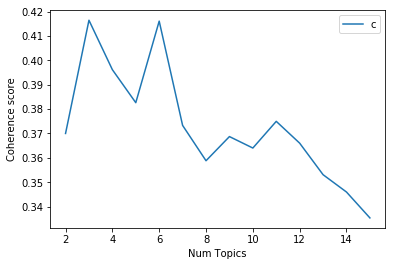

In [236]:
# Show graph
limit=16; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [247]:
# Select the model and print the topics
optimal_model = model_list[4]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.174*"service" + 0.063*"time" + 0.052*"good" + 0.050*"cleanly" + '
  '0.032*"customer" + 0.025*"month" + 0.020*"price" + 0.020*"year" + '
  '0.015*"convenient" + 0.015*"people"'),
 (1,
  '0.060*"lose" + 0.058*"item" + 0.036*"day" + 0.029*"send" + 0.024*"back" + '
  '0.024*"find" + 0.022*"week" + 0.019*"clothing" + 0.018*"miss" + '
  '0.016*"cleanly"'),
 (2,
  '0.052*"order" + 0.034*"customer" + 0.030*"deliver" + 0.029*"call" + '
  '0.028*"service" + 0.026*"experience" + 0.023*"laundry" + 0.023*"receive" + '
  '0.022*"email" + 0.020*"issue"'),
 (3,
  '0.084*"time" + 0.062*"delivery" + 0.046*"pick" + 0.036*"drop" + '
  '0.031*"make" + 0.029*"hour" + 0.026*"pickup" + 0.026*"work" + '
  '0.023*"schedule" + 0.022*"late"'),
 (4,
  '0.125*"laundry" + 0.086*"cleanly" + 0.048*"great" + 0.048*"fold" + '
  '0.031*"easy" + 0.030*"app" + 0.024*"love" + 0.024*"smell" + 0.019*"nice" + '
  '0.019*"recommend"'),
 (5,
  '0.110*"clothe" + 0.072*"clean" + 0.071*"dry" + 0.049*"bag" + 0.044*"back" 

In [248]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(positive['review'].values)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)



In [249]:
#positive['review'].values

In [250]:

df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=positive)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,4.0,0.2300,"laundry, cleanly, great, fold, easy, app, love...",I used this app for the first time last Friday...
1,1,1.0,0.2239,"lose, item, day, send, back, find, week, cloth...","Lost items, slow customer service (only availa..."
2,2,1.0,0.2306,"lose, item, day, send, back, find, week, cloth...",BEYOND TERRIBLE SERVICE. I'm not one to write ...
3,3,5.0,0.3526,"clothe, clean, dry, bag, back, wash, shirt, gi...",This was my first time using Cleanly. I decide...
4,4,5.0,0.2276,"clothe, clean, dry, bag, back, wash, shirt, gi...",Used cleanly again and they lost my entire bag...
5,5,0.0,0.2682,"service, time, good, cleanly, customer, month,...",****Updated review****I've attached 2 screensh...
6,6,5.0,0.2191,"clothe, clean, dry, bag, back, wash, shirt, gi...",As per previous reviews absolutely horrible cu...
7,7,0.0,0.2588,"service, time, good, cleanly, customer, month,...",This is the WORST DRYCLEANING SERVICE IN THE H...
8,8,1.0,0.2538,"lose, item, day, send, back, find, week, cloth...",Well I'm writing this now in hopes I'll get so...
9,9,1.0,0.2417,"lose, item, day, send, back, find, week, cloth...",Cleanly lost $$$ thousands of dollars of desig...


Topic: 0.0


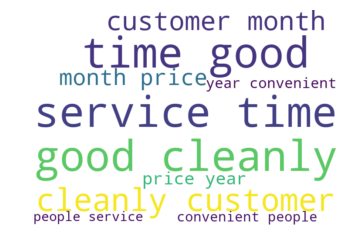

Topic: 1.0


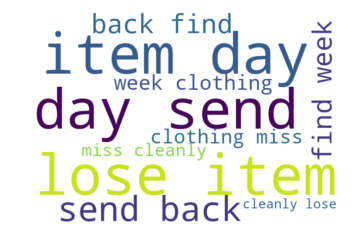

Topic: 2.0


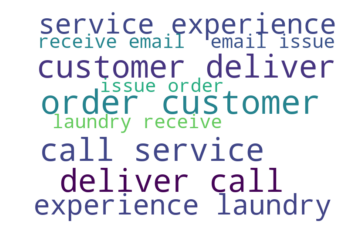

Topic: 3.0


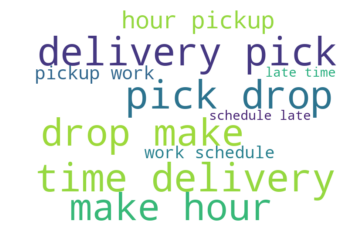

Topic: 4.0


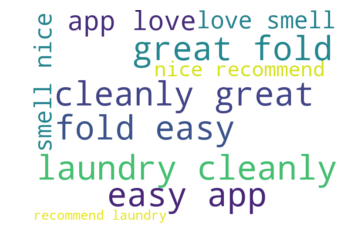

Topic: 5.0


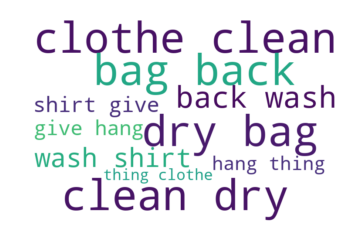

In [283]:
#Topic keys
from wordcloud import WordCloud
import matplotlib.pyplot as plt
Topic_keys = pd.DataFrame(df_dominant_topic['Keywords'].groupby(df_dominant_topic['Dominant_Topic']).apply(list))

Topic_keys['Topic'] = Topic_keys.index
Topic_keys.index=range(len(Topic_keys.index))

for i in range(len(Topic_keys)):
    
    text=' '.join(Topic_keys['Keywords'][i]) 

    wordcloud = WordCloud(width=700, height=500, margin=0, background_color="white").generate(text)

    print('Topic: %s' % (Topic_keys['Topic'][i]))
    # Display the generated image:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.margins(x=0, y=0)
    plt.show()
  

Text(0.5,0,'Topic_Proportion')

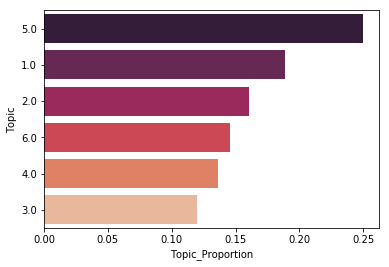

In [252]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)


# Show
topic_prop = pd.DataFrame(topic_contribution)
topic_prop['Topic'] = topic_prop.index
topic_prop['Topic'] = topic_prop['Topic']+1
topic_prop.index = range(len(topic_prop.index))
topic_prop = topic_prop.rename(columns={'Dominant_Topic':'Topic_Proportion'})

#topic_prop.style.format({'Topic_Proportion': "{:.2%}"})
import seaborn as sns
ax = sns.barplot(x='Topic_Proportion', y='Topic', data=topic_prop,  orient = 'h',palette="rocket", order =topic_prop['Topic'] )
ax.set_xlabel('Topic_Proportion')

In [253]:
from gensim.models.ldamodel import LdaModel
def convertldaGenToldaMallet(mallet_model):
    model_gensim = LdaModel(
        id2word=mallet_model.id2word, num_topics=mallet_model.num_topics,
        alpha=mallet_model.alpha, eta=0,
    )
    model_gensim.state.sstats[...] = mallet_model.wordtopics
    model_gensim.sync_state()
    return model_gensim

In [254]:
lda_model = convertldaGenToldaMallet(optimal_model)

In [255]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word, sort_topics=False)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.210368 -0.110424       1        1  15.334727
1     -0.214294 -0.006925       2        1  17.510450
2      0.099470 -0.281581       3        1  17.526411
3      0.145429  0.379023       4        1  17.236290
4      0.115479  0.003665       5        1  15.480651
5     -0.356452  0.016242       6        1  16.911472, topic_info=     Category         Freq         Term        Total  loglift  logprob
52    Default  1388.000000      service  1388.000000  30.0000  30.0000
31    Default  1029.000000      laundry  1029.000000  29.0000  29.0000
70    Default   826.000000       clothe   826.000000  28.0000  28.0000
59    Default  1059.000000         time  1059.000000  27.0000  27.0000
7     Default   533.000000        clean   533.000000  26.0000  26.0000
153   Default   527.000000          dry   527.000000  25.0000  25.0000
334   Default   469.000000     delivery   469.000000  24.0000  24.0000
77    Default   464.000000         lose   464.000000  23.0000  23.0000
69    Default  1172.000000      cleanly  1172.000000  22.0000  22.0000
76    Default   476.000000         item   476.000000  21.0000  21.0000
40    Default   402.000000        order   402.000000  20.0000  20.0000
4     Default   365.000000          bag   365.000000  19.0000  19.0000
23    Default   350.000000         good   350.000000  18.0000  18.0000
24    Default   327.000000        great   327.000000  17.0000  17.0000
20    Default   323.000000         fold   323.000000  16.0000  16.0000
179   Default   325.000000         wash   325.000000  15.0000  15.0000
3     Default   514.000000         back   514.000000  14.0000  14.0000
43    Default   397.000000         pick   397.000000  13.0000  13.0000
71    Default   478.000000     customer   478.000000  12.0000  12.0000
100   Default   273.000000         drop   273.000000  11.0000  11.0000
10    Default   274.000000          day   274.000000  10.0000  10.0000
243   Default   236.000000         make   236.000000   9.0000   9.0000
11    Default   233.000000      deliver   233.000000   8.0000   8.0000
392   Default   213.000000         easy   213.000000   7.0000   7.0000
283   Default   224.000000         call   224.000000   6.0000   6.0000
28    Default   219.000000         hour   219.000000   5.0000   5.0000
51    Default   220.000000         send   220.000000   4.0000   4.0000
2     Default   345.000000          app   345.000000   3.0000   3.0000
515   Default   203.000000   experience   203.000000   2.0000   2.0000
157   Default   319.000000         give   319.000000   1.0000   1.0000
...       ...          ...          ...          ...      ...      ...
158    Topic6   179.893082         hang   179.893082   1.7772  -3.7203
349    Topic6    88.642967         star    88.642967   1.7772  -4.4280
130    Topic6    79.517960        stain    79.517960   1.7772  -4.5366
404    Topic6    76.910812          put    76.910812   1.7772  -4.5700
358    Topic6    75.607239         ruin    75.607239   1.7772  -4.5871
660    Topic6    74.303673        dress    74.303673   1.7772  -4.6045
139    Topic6    66.482224        white    66.482224   1.7772  -4.7157
963    Topic6    48.232204          top    48.232204   1.7772  -5.0366
688    Topic6    41.714340  instruction    41.714340   1.7772  -5.1818
173    Topic6    39.107193        small    39.107193   1.7772  -5.2463
414    Topic6    33.892899          add    33.892899   1.7772  -5.3894
776    Topic6    33.892899      regular    33.892899   1.7772  -5.3894
743    Topic6    32.589325      quickly    32.589325   1.7772  -5.4286
92     Topic6    29.982182        color    29.982182   1.7772  -5.5120
707    Topic6    29.982182          wet    29.982182   1.7772  -5.5120
1013   Topic6    28.678608       bleach    28.678608   1.7772  -5.5565
184    Topic6    28.678608       chance    28.678608   1.7772  -5.5565
276    Topic6    28.678608         wear    28.

In [256]:
p = pyLDAvis.gensim.prepare(lda_model, corpus, id2word, sort_topics=False)
pyLDAvis.save_html(p, 'lda_all.html')

In [277]:
df_topic_sents_keywords[0][180]

"We were fine for a while...but now i'm done. Give delivery person TWO FULL BAGS OF LAUNDRY. One PURPLE CLEANLY BAG. One RED LAUNDRY BAG. I received 1/4th of my clothes in a random BLACK bag! Weeks worth of clothes, TWO LARGE COMFORTERS all gone! Cleanly is performing searches but comes up empty. NEVER AGAIN! Save yourself the trouble."

In [274]:
df_topic_sents_keywords['Dominant_Topic'] = df_topic_sents_keywords['Dominant_Topic'].astype(int)
df_topic_sents_keywords[df_topic_sents_keywords['Dominant_Topic']==5]
#df_topic_sents_keywords[0][180]

,Dominant_Topic,Perc_Contribution,Topic_Keywords,0
3,5,0.3526,"clothe, clean, dry, bag, back, wash, shirt, gi...",This was my first time using Cleanly. I decide...
4,5,0.2276,"clothe, clean, dry, bag, back, wash, shirt, gi...",Used cleanly again and they lost my entire bag...
6,5,0.2191,"clothe, clean, dry, bag, back, wash, shirt, gi...",As per previous reviews absolutely horrible cu...
25,5,0.2441,"clothe, clean, dry, bag, back, wash, shirt, gi...",Astounding amount of waste for just a few dry ...
32,5,0.3010,"clothe, clean, dry, bag, back, wash, shirt, gi...","I've used Cleanly twice, once smoothly without..."
42,5,0.2765,"clothe, clean, dry, bag, back, wash, shirt, gi...",This is one if the worst dry cleaning services...
68,5,0.3049,"clothe, clean, dry, bag, back, wash, shirt, gi...",I've used them for years and was decently happ...
69,5,0.3399,"clothe, clean, dry, bag, back, wash, shirt, gi...",I started using Cleanly laundry services this ...
84,5,0.5172,"clothe, clean, dry, bag, back, wash, shirt, gi...",I have three items for my previous request! 1....
95,5,0.2116,"clothe, clean, dry, bag, back, wash, shirt, gi...",This is the absolute WORST laundry service. I ...


In [227]:
mallet_path = 'mallet-2.0.8/bin/mallet'
positive  =df_topic_sents_keywords[df_topic_sents_keywords['Dominant_Topic']==1]

In [228]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=12, step=1)

,Dominant_Topic,Perc_Contribution,Topic_Keywords,0
10,1,0.2409,"service, good, great, fold, easy, clean, app, ...",I've used them for a few years now. We have ha...
12,1,0.2388,"service, good, great, fold, easy, clean, app, ...",I haven't had any problems with Cleanly and ha...
43,1,0.2621,"service, good, great, fold, easy, clean, app, ...",I've had good experiences with pickup and drop...
44,1,0.2690,"service, good, great, fold, easy, clean, app, ...",They fulfilled every aspect of the services ad...
48,1,0.2937,"service, good, great, fold, easy, clean, app, ...",Cleanly is great - it is so much easier to hav...
58,1,0.2786,"service, good, great, fold, easy, clean, app, ...",I will probably never do my own laundry again!...
73,1,0.2581,"service, good, great, fold, easy, clean, app, ...",I live on the sixth floor of a walk up with no...
75,1,0.2870,"service, good, great, fold, easy, clean, app, ...",Cleanly is a really nice laundry service! The ...
76,1,0.2863,"service, good, great, fold, easy, clean, app, ...",We have no laundry in our building and the clo...
80,1,0.2295,"service, good, great, fold, easy, clean, app, ...",Love cleanly support service team and the deli...


In [282]:
df_dominant_topic[['Dominant_Topic', 'Topic_Perc_Contrib', 'Text']].to_csv('yelp_all_reviews.csv', index = False)